In [0]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/

In [0]:
!kaggle competitions download -c bengaliai-cv19

  0% 0.00/4.72k [00:00<?, ?B/s]
100% 4.72k/4.72k [00:00<00:00, 15.0MB/s]
  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 90.1MB/s]
  0% 0.00/1.70k [00:00<?, ?B/s]
100% 1.70k/1.70k [00:00<00:00, 1.74MB/s]
 99% 978M/992M [00:14<00:00, 34.6MB/s]
100% 992M/992M [00:14<00:00, 72.4MB/s]
 98% 968M/991M [00:11<00:00, 36.8MB/s]
100% 991M/991M [00:11<00:00, 92.2MB/s]
  0% 0.00/944 [00:00<?, ?B/s]
100% 944/944 [00:00<00:00, 827kB/s]
 99% 980M/986M [00:21<00:00, 109MB/s] 
100% 986M/986M [00:21<00:00, 48.5MB/s]
  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 172MB/s]
 99% 985M/993M [00:25<00:00, 17.9MB/s]
100% 993M/993M [00:25<00:00, 40.6MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 149MB/s]
  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 80.0MB/s]
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 182MB/s]


In [0]:
!unzip test_image_data_0.parquet.zip
!unzip test_image_data_1.parquet.zip
!unzip test_image_data_2.parquet.zip
!unzip test_image_data_3.parquet.zip
!unzip train_image_data_0.parquet.zip
!unzip train_image_data_1.parquet.zip
!unzip train_image_data_2.parquet.zip
!unzip train_image_data_3.parquet.zip

Archive:  test_image_data_0.parquet.zip
  inflating: test_image_data_0.parquet  
Archive:  test_image_data_1.parquet.zip
  inflating: test_image_data_1.parquet  
Archive:  test_image_data_2.parquet.zip
  inflating: test_image_data_2.parquet  
Archive:  test_image_data_3.parquet.zip
  inflating: test_image_data_3.parquet  
Archive:  train_image_data_0.parquet.zip
  inflating: train_image_data_0.parquet  
Archive:  train_image_data_1.parquet.zip
  inflating: train_image_data_1.parquet  
Archive:  train_image_data_2.parquet.zip
  inflating: train_image_data_2.parquet  
Archive:  train_image_data_3.parquet.zip
  inflating: train_image_data_3.parquet  


In [0]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image

In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [0]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [0]:
len(train_df.grapheme_root.unique())

168

In [0]:
len(train_df.vowel_diacritic.unique())

11

In [0]:
len(train_df.consonant_diacritic.unique())

7

In [0]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [0]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, labels, train_images, image_ids, transforms=None):
        super(Dataset, self).__init__()
        self.image_ids = image_ids
        self.train_images = train_images
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        image_id = self.image_ids.iloc[index]
        img_array = np.zeros((137, 236, 3), dtype='uint8')
        img_array[:, :, 0] = 255 - self.train_images[index].reshape(137, 236)
        img_array[:, :, 1] = img_array[:, :, 0]
        img_array[:, :, 2] = img_array[:, :, 0]
        img = Image.fromarray(img_array)
        grapheme_root = self.labels[index, 1]
        vowel_diacritic = self.labels[index, 2]
        consonant_diacritic = self.labels[index, 3]

        if self.transforms:
            img = self.transforms(img)

        return img, (grapheme_root, vowel_diacritic, consonant_diacritic)

    def __len__(self,):
        return len(self.image_ids)

In [0]:
class GraphemeModel(nn.Module):

    def __init__(self):
        super(GraphemeModel, self).__init__()
        self.base_model = torchvision.models.resnet50(pretrained=False)
        # self.fc = nn.Linear(1000, 256)
        self.fc_root = nn.Linear(1000, 168)
        self.fc_vowel = nn.Linear(1000, 11)
        self.fc_consonant = nn.Linear(1000, 7)
        
    def forward(self, inp):
        x = self.base_model(inp)
        # x = x.view(x.shape[0], -1)
        # x = F.relu(self.fc(x))
        root_output = self.fc_root(x)
        vowel_output = self.fc_vowel(x)
        consonant_output = self.fc_consonant(x)

        return (root_output, vowel_output, consonant_output)

In [0]:
train_image_data_0 = pd.read_parquet('train_image_data_0.parquet', engine='auto')

In [0]:
train_image_data_1 = pd.read_parquet('train_image_data_1.parquet', engine='auto')

In [0]:
train_image_data_2 = pd.read_parquet('train_image_data_2.parquet', engine='auto')

In [0]:
train_image_data_3 = pd.read_parquet('train_image_data_3.parquet', engine='auto')

In [0]:
train_matrix = np.concatenate([
                    train_image_data_0.drop(columns=['image_id']).values,
                    train_image_data_1.drop(columns=['image_id']).values,
                    train_image_data_2.drop(columns=['image_id']).values,
                ])
    

In [0]:
transforms = torchvision.transforms.Compose([
                              # torchvision.transforms.Resize((224, 224)),
                              torchvision.transforms.RandomAffine(degrees=0, scale=(0.9, 1.1), translate=(0.1, 0.1)),
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0,), (1.,)),

            ])

In [0]:
transforms1 = torchvision.transforms.Compose([
                              # torchvision.transforms.Resize((224, 224)),
                              # torchvision.transforms.RandomRotation(degrees=20),
                              # torchvision.transforms.RandomPerspective(),
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0,), (1.,)),

            ])

In [0]:
val_matrix = train_image_data_3.drop(columns=['image_id']).values

In [0]:
val_dataset = Dataset(labels=train_df.iloc[50210*3:50210*4].values, train_images=val_matrix, image_ids=train_image_data_3.image_id, transforms=transforms1)

In [0]:
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

In [0]:
image_ids = train_image_data_0.image_id.append(train_image_data_1.image_id).append(train_image_data_2.image_id)

In [0]:
train_dataset = Dataset(labels=train_df.iloc[:50210*3].values, train_images=train_matrix, image_ids=image_ids, transforms=transforms)

In [0]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [0]:
model = GraphemeModel()

In [0]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [0]:
model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.00001)

In [0]:
def accuracy(y_actual, y_pred):
    return (y_actual == y_pred).sum().item() / y_actual.shape[0]

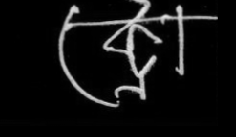

In [0]:
t(img)

In [0]:
model.train()
model.base_model.train()
for epoch in range(3):
    for x, (root, vowel, consonant) in train_dataloader:
        opt.zero_grad()
        output = model(x.to(device))
        loss_root = criterion(output[0], root.to(device))
        loss_vowel = criterion(output[1], vowel.to(device))
        loss_consonant = criterion(output[2], consonant.to(device))
        loss = loss_root * 2 + loss_vowel + loss_consonant
        loss.backward()
        print('Accuracy: ', accuracy(root, output[0].detach().cpu().argmax(1)), end=', ')
        # loss_root.backward()
        opt.step()
        print('Loss: ', loss.item())

Accuracy:  0.9375, Loss:  0.668513298034668
Accuracy:  0.953125, Loss:  0.3417900800704956
Accuracy:  0.96875, Loss:  0.23682381212711334
Accuracy:  0.984375, Loss:  0.3091973662376404
Accuracy:  0.984375, Loss:  0.4172873795032501
Accuracy:  0.90625, Loss:  0.7336642742156982
Accuracy:  0.9375, Loss:  0.5209102630615234
Accuracy:  0.90625, Loss:  0.5056759715080261
Accuracy:  0.921875, Loss:  0.5816317200660706
Accuracy:  0.984375, Loss:  0.17625820636749268
Accuracy:  0.890625, Loss:  0.821493923664093
Accuracy:  0.921875, Loss:  0.7236595749855042
Accuracy:  0.984375, Loss:  0.5171566009521484
Accuracy:  0.96875, Loss:  0.27135348320007324
Accuracy:  0.96875, Loss:  0.3923593759536743
Accuracy:  0.953125, Loss:  0.6037377715110779
Accuracy:  0.96875, Loss:  0.396128386259079
Accuracy:  0.9375, Loss:  0.8164109587669373
Accuracy:  0.953125, Loss:  0.4914555549621582
Accuracy:  0.953125, Loss:  0.3907659351825714
Accuracy:  0.9375, Loss:  0.4809139370918274
Accuracy:  0.953125, Loss: 

KeyboardInterrupt: ignored

In [0]:
with open('model.pth', 'wb') as f:
  torch.save(model, f)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GraphemeModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/pytho

In [0]:
class TestDataset(torch.utils.data.Dataset):

    def __init__(self, test_images, image_ids, transforms=None):
        super(TestDataset, self).__init__()
        self.image_ids = image_ids
        self.test_images = test_images
        self.transforms = transforms

    def __getitem__(self, index):
        image_id = self.image_ids.iloc[index]
        img_array = np.zeros((137, 236, 3), dtype='uint8')
        img_array[:, :, 0] = self.test_images[index].reshape(137, 236)
        img_array[:, :, 1] = img_array[:, :, 0]
        img_array[:, :, 2] = img_array[:, :, 0]
        img = Image.fromarray(img_array)
        if self.transforms:
            img = self.transforms(img)

        return img

    def __len__(self,):
        return len(self.image_ids)

In [0]:
test_image_data_0 = pd.read_parquet('test_image_data_0.parquet')

In [0]:
test_image_data_1 = pd.read_parquet('test_image_data_1.parquet')

In [0]:
test_image_data_2 = pd.read_parquet('test_image_data_2.parquet')

In [0]:
test_image_data_3 = pd.read_parquet('test_image_data_3.parquet')

In [0]:
test_image_data_0.shape, test_image_data_1.shape, test_image_data_2.shape, test_image_data_3.shape

((3, 32333), (3, 32333), (3, 32333), (3, 32333))

In [0]:
test_matrix = np.concatenate([
                              test_image_data_0.drop(columns=['image_id']).values,
                              test_image_data_1.drop(columns=['image_id']).values,
                              test_image_data_2.drop(columns=['image_id']).values,
                              test_image_data_3.drop(columns=['image_id']).values])

In [0]:
test_matrix.shape

(12, 32332)

In [0]:
image_ids = test_image_data_0.image_id.append(test_image_data_1.image_id).append(test_image_data_2.image_id).append(test_image_data_3.image_id)

In [0]:
test_dataset = TestDataset(test_images=test_matrix, image_ids=image_ids, transforms=transforms)

In [0]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)

In [0]:
model.eval()
for x in test_dataloader:
  output = model(x.to(device))

In [0]:
output